<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:10px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Butterfly Image Classification 🦋</b></div>

<div style="text-align: center;">
    <img src="https://www.mdzol.com/u/fotografias/m/2022/4/14/f1280x720-1206481_1338156_5050.jpg" alt="alzheimers" style="width:100%; height:auto; border-radius: 30px;">
</div>

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Import Libraries 🦋</b></div>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

2024-08-05 03:55:34.984765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 03:55:34.984934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 03:55:35.164042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Data Analyisis and Visualization🦋</b></div>

In [2]:
df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
df.head(10)

filename                     label
0   Image_1.jpg          SOUTHERN DOGFACE
1   Image_2.jpg                    ADONIS
2   Image_3.jpg            BROWN SIPROETA
3   Image_4.jpg                   MONARCH
4   Image_5.jpg  GREEN CELLED CATTLEHEART
5   Image_6.jpg           CAIRNS BIRDWING
6   Image_7.jpg  GREEN CELLED CATTLEHEART
7   Image_8.jpg      EASTERN DAPPLE WHITE
8   Image_9.jpg            BROWN SIPROETA
9  Image_10.jpg               RED POSTMAN

In [3]:
len(df)

6499

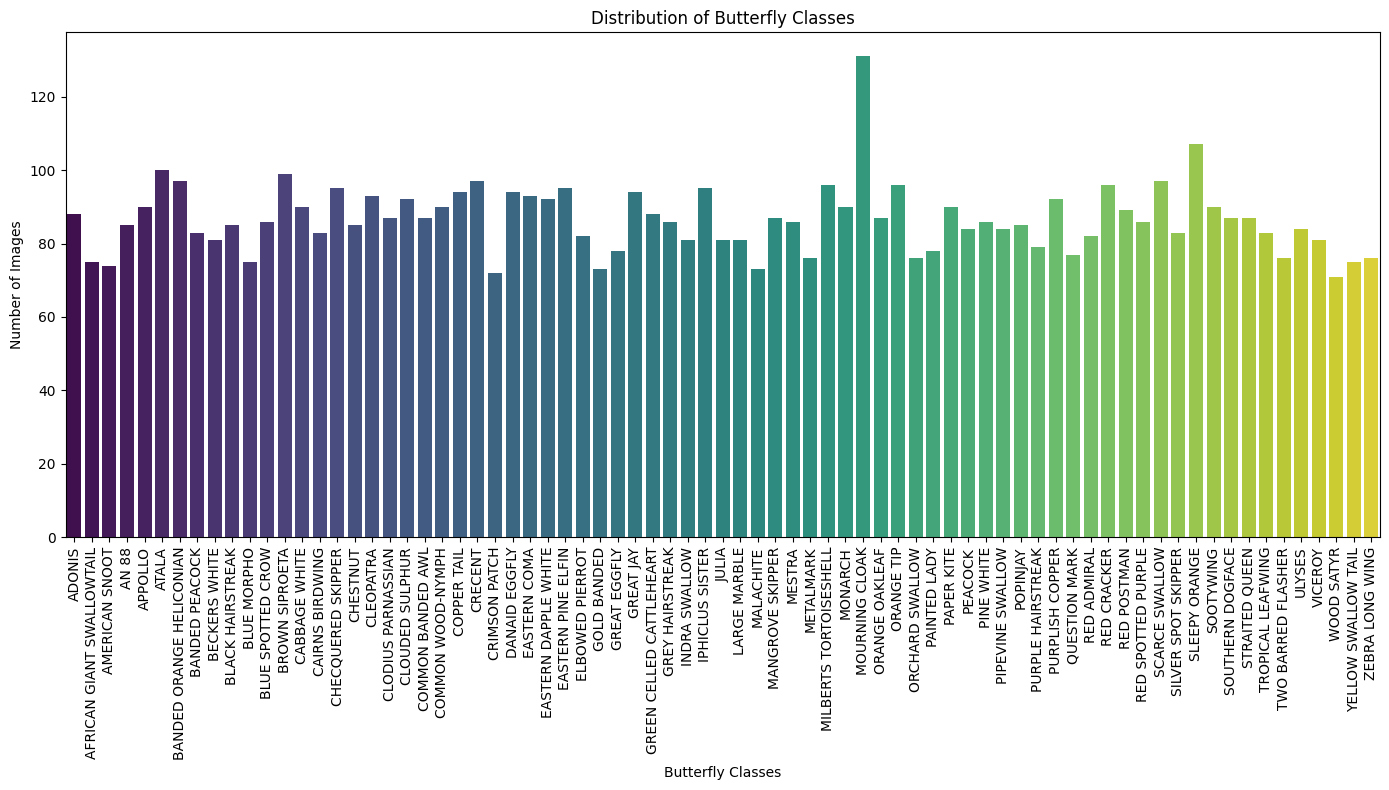

In [4]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

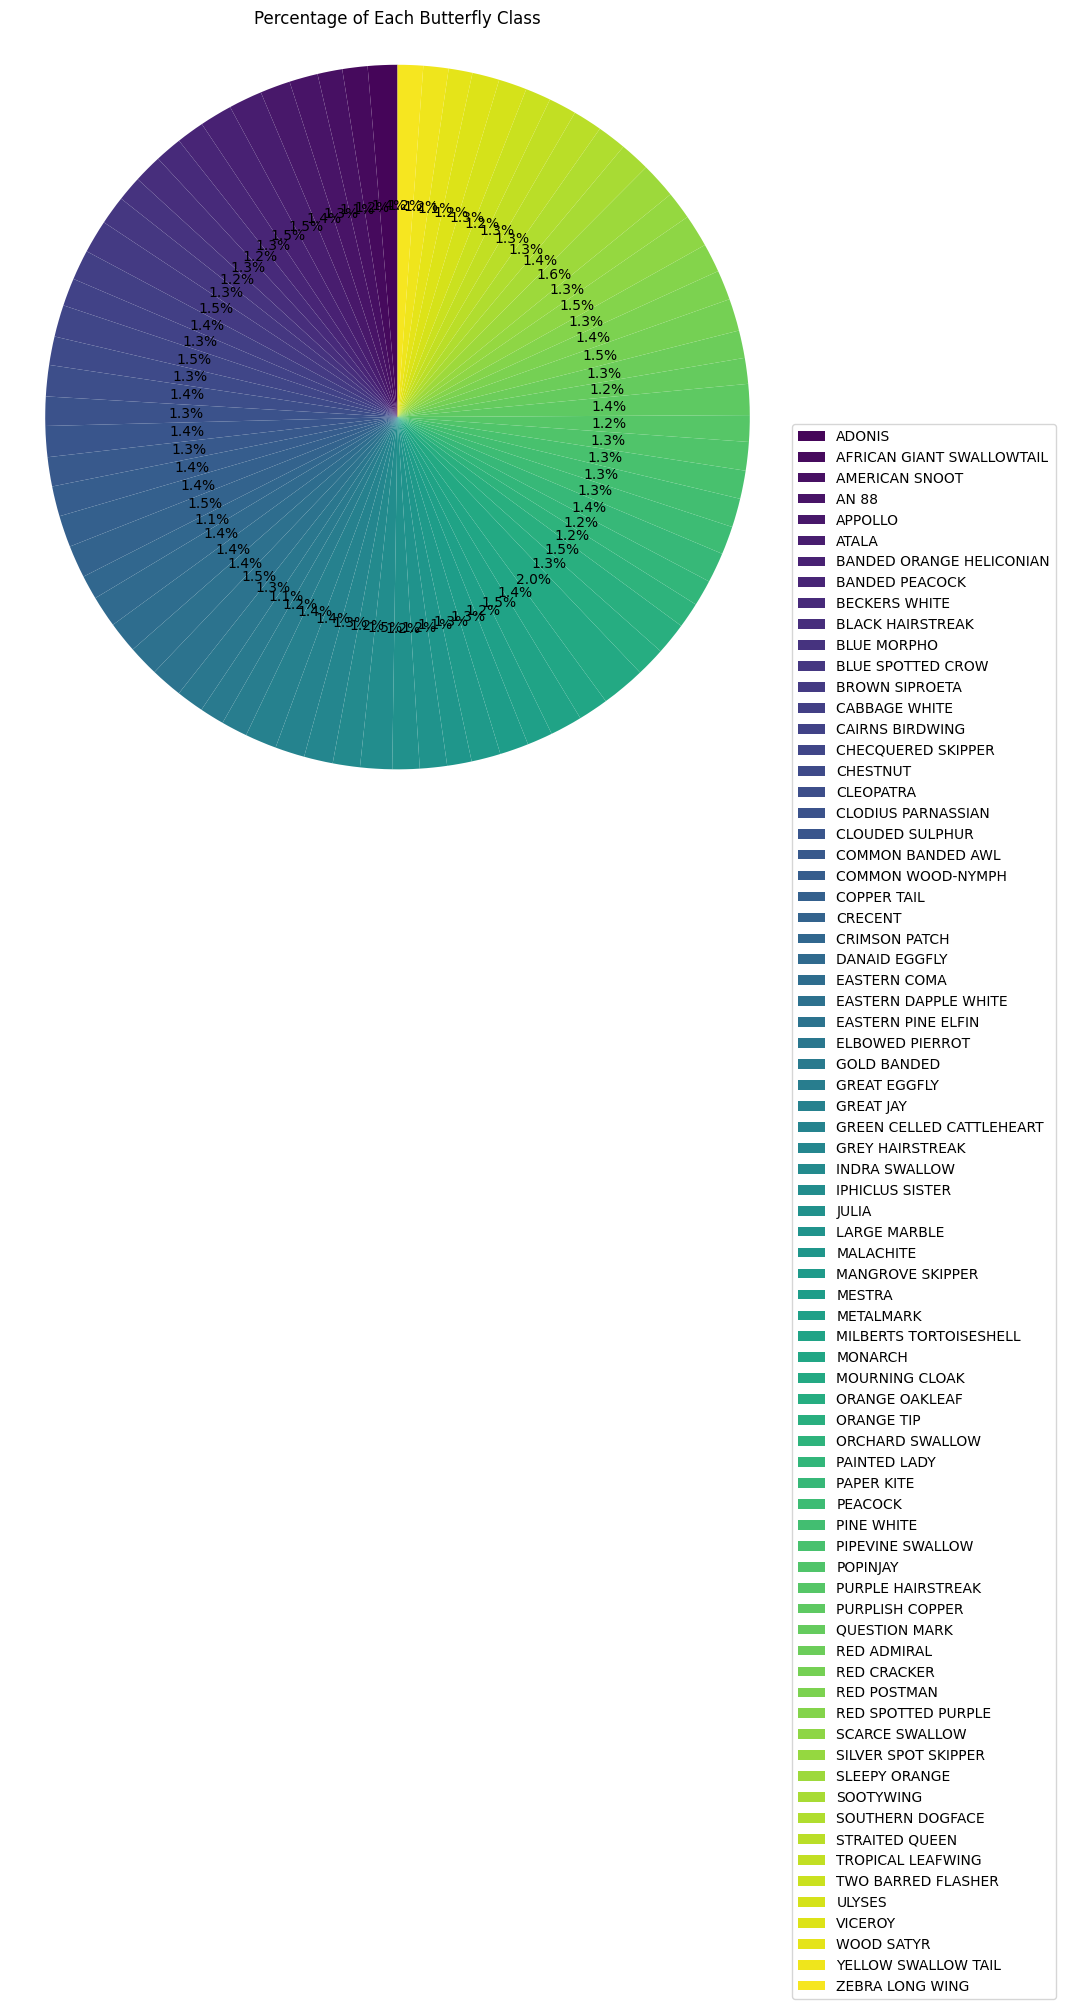

In [5]:
colors = sns.color_palette("viridis", len(class_counts))
class_counts = df['label'].value_counts().sort_index()


plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Each Butterfly Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

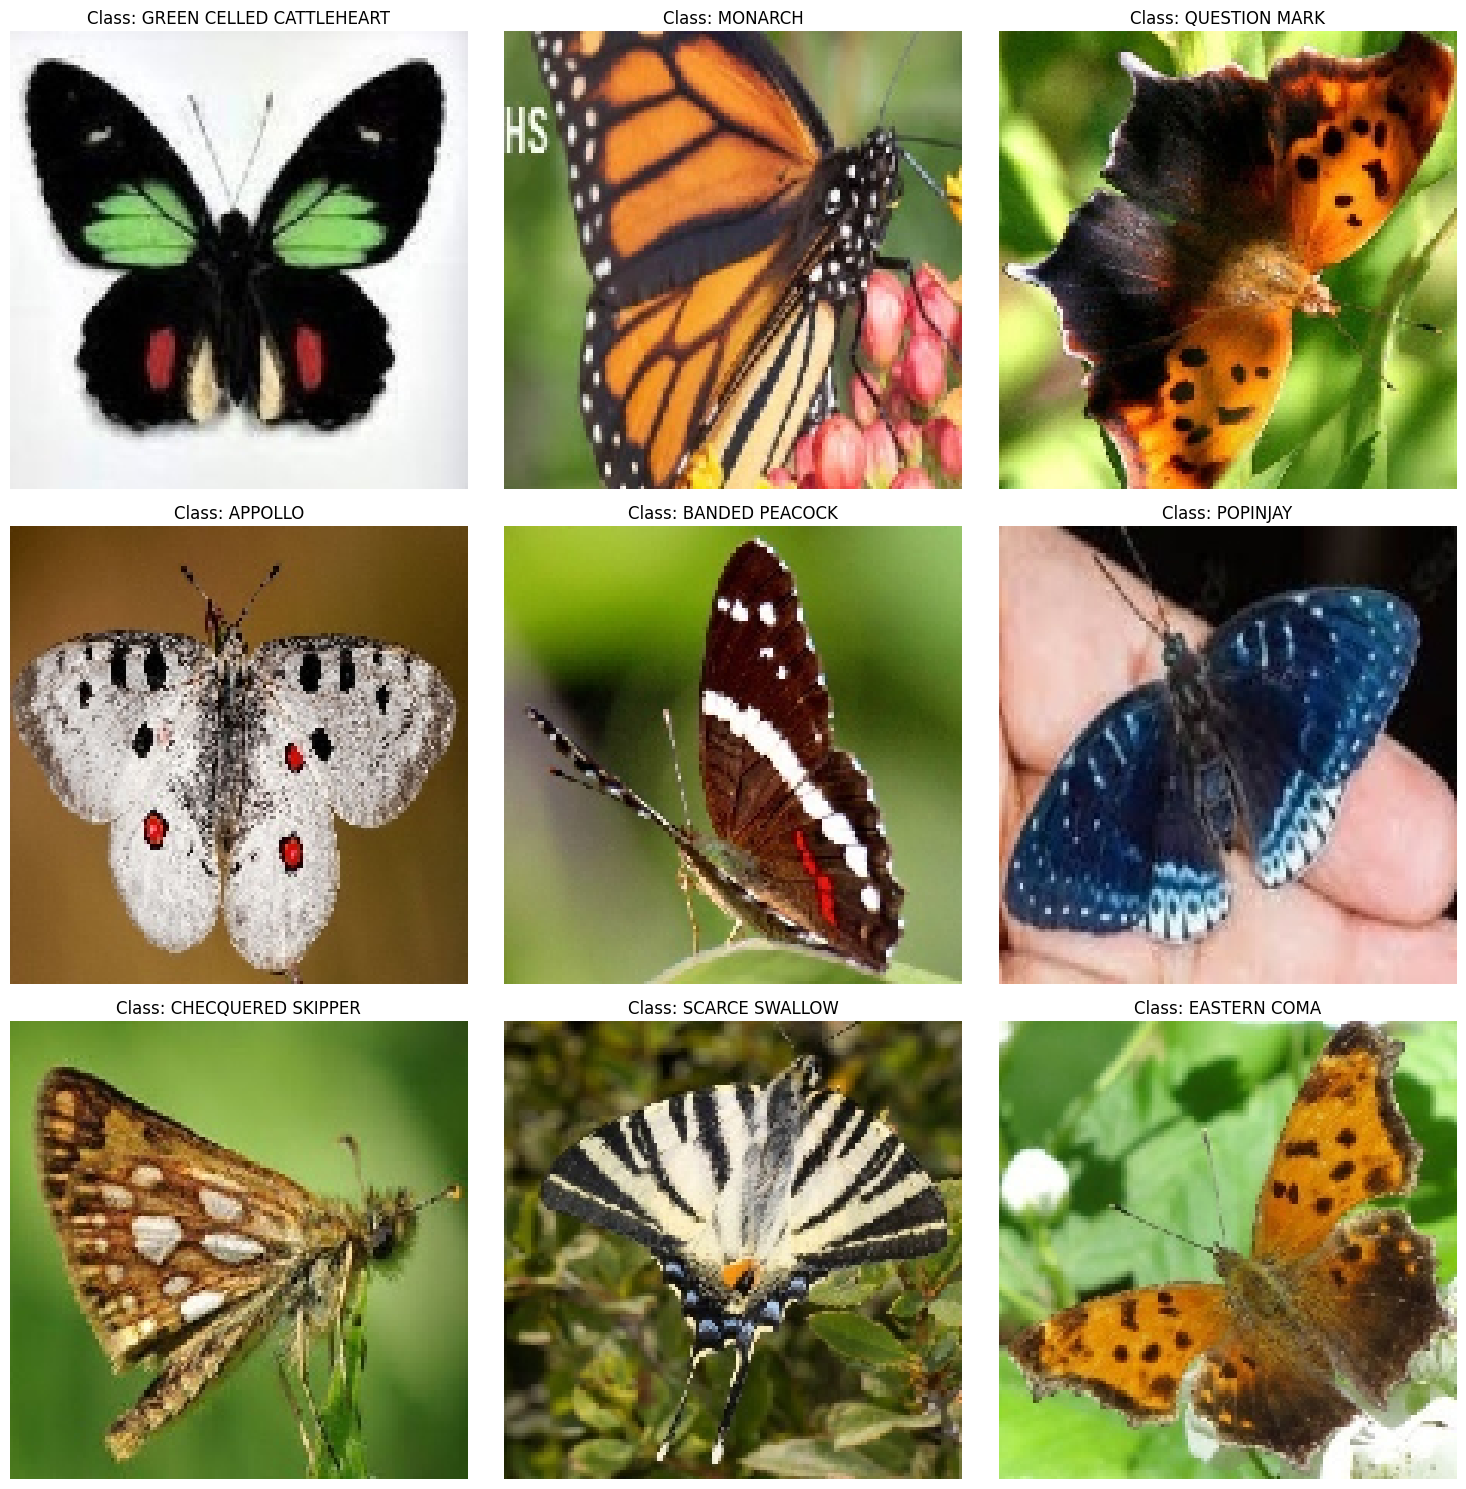

In [6]:
image_dir = "/kaggle/input/butterfly-image-classification/train"

sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Splitting Dataset 🦋</b></div>

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "/kaggle/input/butterfly-image-classification/train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Building the Model 🦋</b></div>

In [8]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.0342 - loss: 4.2343 - val_accuracy: 0.1773 - val_loss: 3.1640
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1562 - loss: 3.1657 - val_accuracy: 0.2000 - val_loss: 3.3282
Epoch 3/40


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


162/162 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.1988 - loss: 3.0903 - val_accuracy: 0.3313 - val_loss: 2.4400
Epoch 4/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.2500 - loss: 2.5613 - val_accuracy: 0.5500 - val_loss: 1.6314
Epoch 5/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.3422 - loss: 2.3838 - val_accuracy: 0.4414 - val_loss: 2.0633
Epoch 6/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4688 - loss: 1.7717 - val_accuracy: 0.4500 - val_loss: 1.7317
Epoch 7/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.4169 - loss: 2.0527 - val_accuracy: 0.4977 - val_loss: 1.7621
Epoch 8/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3125 - loss: 2.7903 - val_accuracy: 0.7000 - val_loss: 1.1415
Epoch 9/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4979 - loss: 1.7674 - val_accuracy: 0.4844 - val_loss: 1.8823
Epoch 10/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.3125 - loss: 2.2106 - val_accuracy: 0.

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Evaluating the Model 🦋</b></div>

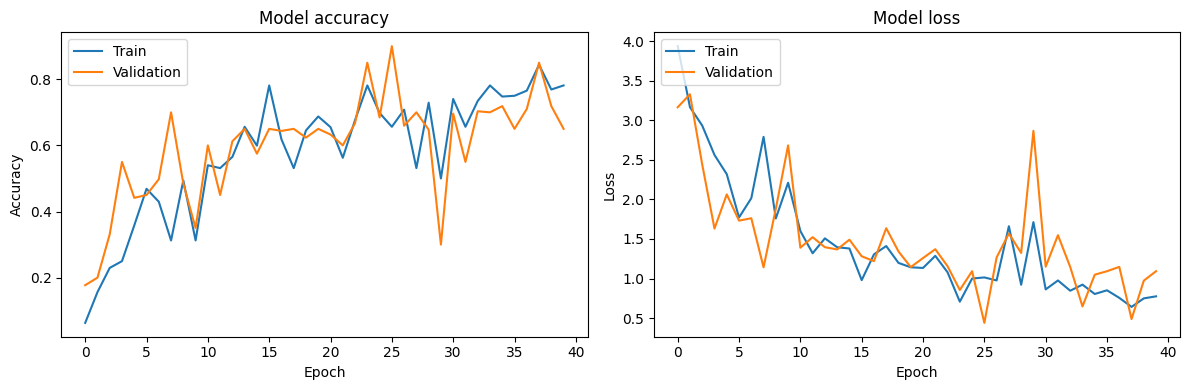

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


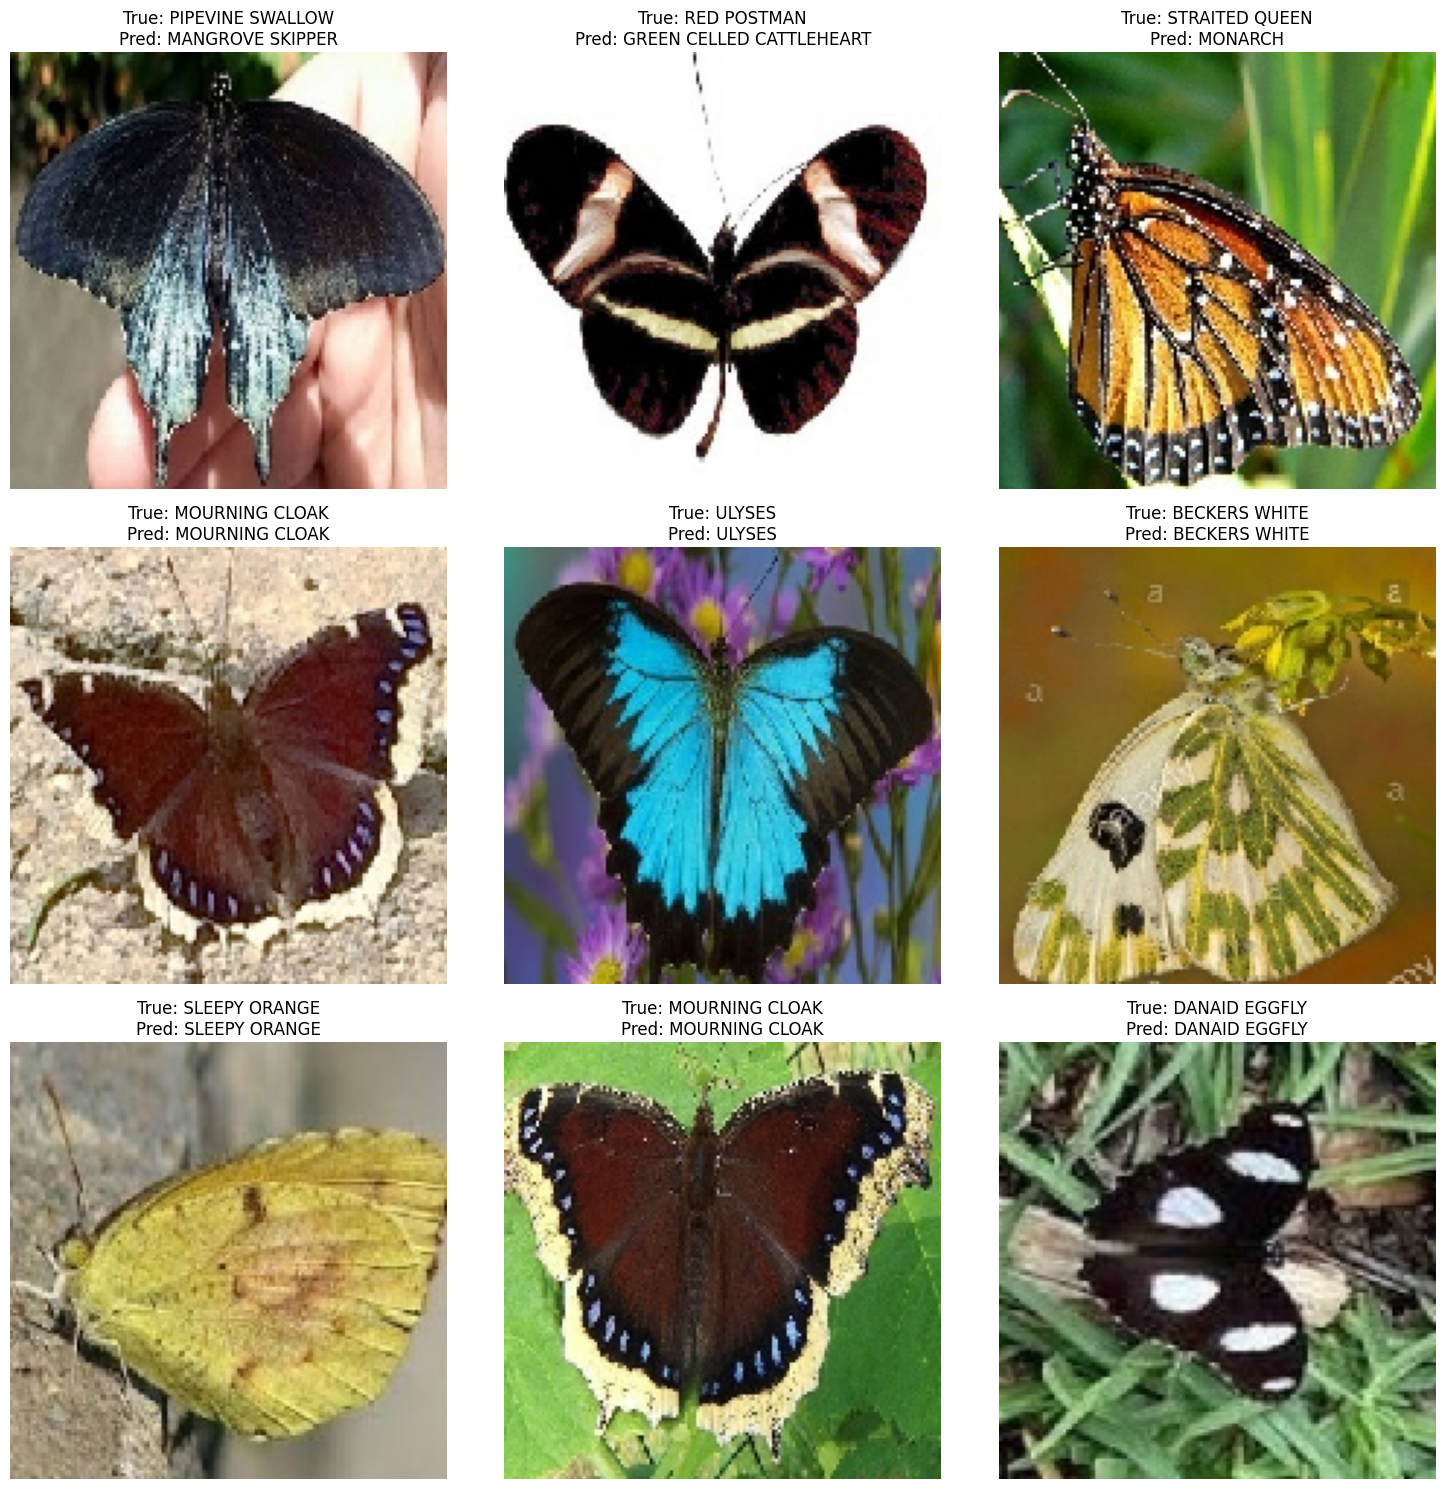

In [11]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>🦋 Conclusion 🦋</b></div>

In this notebook, the butterfly multiclass image classification was developed obtaining an accuracy higher than 70%.

If you found this notebook helpful, please consider upvoting it. Your positive feedback helps us to continue providing valuable content and assists others in discovering useful resources.

Your support is greatly appreciated 🩵
